## Gradient Boosting (xgBoost)

**Gradient Boosting** with xgBoost. **xgBoost** is one of the most popular gradient boosting library in public domain.
**xgBoost** added some novel innovations to Gradient boosting that make it very successful. Some of those innovations are listed below:
1. A new regularized learning objective 

    $\mathcal{L} = \sum_{i}l(\hat{y}_i,y_i) + \sum_k\Omega(f_k)$, where $\Omega(f) = \gamma T + \frac{1}{2}\lambda ||w||^2$

2. Weighted approximate histogram based split finding. **xgBoost** has a mode to do approximate splitting of the tree based on an histogram. For exact splitting of a node the time complexity is $\mathcal{O}(n \text{ log}(n)\text{ }m)$ where $m$ is the number of features and $n$ is the number of samples and for histogram bases splitting the complexity is $\mathcal{O}(n\text{}m)$ for histogram building and $\mathcal{O}(b \text{}m)$ for split point finding where $b$ is the number of bins.

3. Sparsity aware split finding. What **xgBoost** does is for every node there is a default split direction, that is the direction which leads to maximum reduction in loss. If the data in missing then that default direction is picked.

4. Parallel and distributed computing. And out-of-core training of models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

**Load adults dataset**

https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
#Load dataset
colnames = ['age', 'workclass', 'fnlwgt', 'education', 
            'education-num', 'marital-status', 'occupation', 'relationship',
           'race', 'sex', 'capital-gain','capital-loss', 'hours-per-week', 
           'native-country', 'target']
df_adult_train=pd.read_csv("../data/adults/adult.data",header=None, names=colnames)
df_adult_test=pd.read_csv("../data/adults/adult.test",header=None, names=colnames) 

In [3]:
df_adult_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#Handle missing data
df_adult_train.replace(' ?' , np.nan, inplace=True)
df_adult_test.replace(' ?' , np.nan, inplace=True)

In [5]:
#Apply one hot encoding to categorical columns
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 
              'relationship', 'race', 'sex', 'native-country']
def applyOneHot(df, cat_columns):
    onehot_df = df[cat_columns]
    onehot_df = pd.get_dummies(onehot_df, columns = cat_columns)
    onehot_drop = df.drop(cat_columns, axis = 1)
    df = pd.concat([onehot_drop, onehot_df], axis = 1)
    return df

df_adult_train = applyOneHot(df_adult_train, cat_columns)
df_adult_test = applyOneHot(df_adult_test, cat_columns)
#There is no data point with native-country_ Holand-Netherlands in test set lets add that zero column
df_adult_test['native-country_ Holand-Netherlands'] = 0

In [6]:
#There is an extra . in test labels remove that
df_adult_test.replace(to_replace={r' <=50K.': ' <=50K',r' >50K.':' >50K'}, regex=True, inplace=True)

In [7]:
#Apply Label encoder to y
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le = le.fit(df_adult_train['target'])
df_adult_train['target'] = le.transform(df_adult_train['target'])
df_adult_test['target'] = le.transform(df_adult_test['target'])

In [8]:
df_adult_test['target'].unique()

array([0, 1])

In [9]:
#Make X_train, X_test, y_train, y_test
X_train = df_adult_train.drop('target', axis=1).values.astype('float')
y_train = df_adult_train['target'].values.astype('float')
X_test = df_adult_test.drop('target', axis=1).values.astype('float')
y_test = df_adult_test['target'].values.astype('float')

assert y_test.shape[0] == X_test.shape[0]
assert y_train.shape[0] == X_train.shape[0]

print(f"Size of test set = {y_test.shape[0]}")
print(f"Size of train set = {y_train.shape[0]}")

Size of test set = 16281
Size of train set = 32561


In [10]:
#Lets standardize the Xs
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [11]:
#Lets first apply Logistics regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=500)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.853
Test score=0.845


Logistic regression has decent test score of 84.5%.

In [12]:
#Lets fit a single decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=2)
clf = clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=1.0
Test score=0.797


Decision tree has very good train score but bad test score. It seems like it has overfit.

In [13]:
#Now lets fit random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, min_samples_split=2)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=1.0
Test score=0.86


Random forest seems to be over-fitting also.

In [14]:
#Lets use default XgBoost parameters
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.9
Test score=0.872


xgBoost default parameters giving very good performance

<Figure size 1440x1440 with 0 Axes>

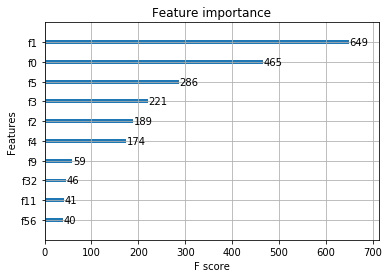

In [15]:
#Lets plot feature importance
plt.figure(figsize=(20,20))
xgb.plot_importance(clf, max_num_features=10)

#### Now lets search parameters of xgBoost to see if we can improve on the default parameters
Some important parameters to search on are 
1. max_depth of each tree 
2. gamma - Regularization penalty for splitting one more level.
3. eta - learning rate
4. Lambda - L2 regularization term on weights
5. Boosting steps 

In [16]:
clf.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [17]:
from sklearn.model_selection import GridSearchCV
# A parameter grid for XGBoost
params = {
        'learning_rate' : [ 0.1, 1],
        'gamma': [0, 1, 2, 10],
        'max_depth': [5, 6, 10],
        'reg_lambda': [0.01, 0.1, 1, 2],
        'n_estimators': [100, 500, 1000]
        }
clf = xgb.XGBClassifier(tree_method='hist')
gs = GridSearchCV(clf, 
                    param_grid=params, 
                    scoring='accuracy',  
                    cv=5,
                    n_jobs=1)
gs = gs.fit(X_train_std, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

Best score = 0.874
{'gamma': 2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'reg_lambda': 1}


In [18]:
clf = xgb.XGBClassifier(tree_method='hist', 
                        gamma=2,
                        learning_rate=0.1,
                        max_depth=6,
                        n_estimators=500,
                        reg_lambda=1)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.889
Test score=0.874


#### One important feature of xgBoost is histogram and approx searches below we will compare the speed advantage of histogram or exact search

In [19]:
%%timeit
#Exact search
clf = xgb.XGBClassifier(tree_method='exact')
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
Train score=0.9
Test score=0.872
10.8 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
#Approx search
clf = xgb.XGBClassifier(tree_method='approx')
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
Train score=0.901
Test score=0.866
10.7 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
#Hist search
clf = xgb.XGBClassifier(tree_method='hist')
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
Train score=0.9
Test score=0.87
902 ms ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see from above that there is not much difference between exact and approx. But hist is **10x** faster than either.

#### What is the difference between hist and approx?
Approximate splitting method in **xgBoost** buckets continuous features into discrete bins to speed up training. The approx method generates a new set of bins for each iteration, whereas the hist method re-uses the bins over multiple iterations.